# Capstone: Exploratory Data Analysis (EDA)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# import project utils
import sys
sys.path.append('../src')

# import constants
import graph_utils


## The Data: San Francisco Police Department Incident Reports

## Understanding the data

Our main objective during the EDA is to understand and prepare the data to answer our Capstone question:

> Can we predict the likelihood of a crime occuring in a specific area at a specific time?

Please reference the [README.md](README.md) for an overview.

Let's dive right in!

## Read the data

The dataset is available as two CSV files with historical data from 2003-2018 and 2018-Present:

* [San Franciso Police Department Incident Reports: Historical 2003 to May 2018](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry/about_data)
* [Police Department Incident Reports: 2018 to Present](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/about_data)

The current data is updated nightly and it takes a few minutes to read and convert the data to a time-series format. So, I've created a set of utilities to optimize data ingestion in the `data_utils.py`.

In [8]:
import data_utils

# Also load the config globals
from data_utils import Config

I periodically refresh the dataset from the [excellent DataSF site](https://www.sf.gov/departments/city-administrator/datasf) to the project `data` directoty, and generate a _clean_ input file transformed as a time-series. I will typically do this a couple of times a week, and save the output as a static comment below so I know what happened.

**Note:**: I'm limiting the report to only the current data for now as the models are very difficult to tune on my current hardware with just the 2018 data alone!

* [Police Department Incident Reports: 2018 to Present](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/about_data)


In [10]:
# Convert the raw SFPD data into a cleansed data file - only to be used when refreshing from new data

current_raw_file = Config.CURR_RAW_FILE
current_clean_file = Config.CURR_CLEAN_FILE

# Uncomment to regenerate the clean data file from raw data - normally just read the clean data as it's MUCH FASTER
# data_utils.generate_clean_csv(current_raw_file, current_clean_file, debug=True)

STATIC COMMENT: OUTPUT SAVED FROM LAST SUCCESSFULL RUN (see timestamp below):
```
Start Time: 10/03/24 15:35:42

Reading file: ../data/Police_Department_Incident_Reports__2018_to_Present_20241003.csv ... Done: 894,585 rows, 35 columns
... Formatting column names ... Done
... Creating timeseries columns: datetime ... 
...... Number of rows where the datetime conversion failed: 0
...... Timespan: 2018-01-01 00:00:00 - 2024-10-02 21:45:00
... Done
... Setting index to datetime ... Done

Current Time: 10/03/24 15:40:44

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 894585 entries, 2023-03-13 23:41:00 to 2023-03-21 17:42:00
Data columns (total 35 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   incident_datetime                                     894585 non-null  object 
 1   incident_date                                         894585 non-null  object 
 2   incident_time                                         894585 non-null  object 
 3   incident_year                                         894585 non-null  int64  
 4   incident_day_of_week                                  894585 non-null  object 
 5   report_datetime                                       894585 non-null  object 
 6   row_id                                                894585 non-null  int64  
 7   incident_id                                           894585 non-null  int64  
 8   incident_number                                       894585 non-null  int64  
 9   cad_number                                            695166 non-null  float64
 10  report_type_code                                      894585 non-null  object 
 11  report_type_description                               894585 non-null  object 
 12  filed_online                                          176471 non-null  object 
 13  incident_code                                         894585 non-null  int64  
 14  incident_category                                     893683 non-null  object 
 15  incident_subcategory                                  893683 non-null  object 
 16  incident_description                                  894585 non-null  object 
 17  resolution                                            894585 non-null  object 
 18  intersection                                          845403 non-null  object 
 19  cnn                                                   845403 non-null  float64
 20  police_district                                       894585 non-null  object 
 21  analysis_neighborhood                                 845233 non-null  object 
 22  supervisor_district                                   844940 non-null  float64
 23  supervisor_district_2012                              845260 non-null  float64
 24  latitude                                              845403 non-null  float64
 25  longitude                                             845403 non-null  float64
 26  point                                                 845403 non-null  object 
 27  neighborhoods                                         828688 non-null  float64
 28  esncag_-_boundary_file                                9512 non-null    float64
 29  central_market/tenderloin_boundary_polygon_-_updated  118263 non-null  float64
 30  civic_center_harm_reduction_project_boundary          115874 non-null  float64
 31  hsoc_zones_as_of_2018-06-05                           186873 non-null  float64
 32  invest_in_neighborhoods_(iin)_areas                   0 non-null       float64
 33  current_supervisor_districts                          845260 non-null  float64
 34  current_police_districts                              844494 non-null  float64
dtypes: float64(14), int64(5), object(16)
memory usage: 245.7+ MB
... Writing file: ../data/incidents_clean.csv (894585, 35) ... Done
Done

End Time: 10/03/24 15:41:22
```

As you can see, there are almost a million samples since 2018!

So, I then generate a few randomly sampled datasets of known percentages, to speed up the data exploration. Again only done when refreshing the dataset. Since we'll be working across multiple randomly selected datafiles, I set a global random_state value from hereon remove any randomization artifacts from one run to the next:

In [13]:
# Consistent random_state for the project
print(f'Project-wide random_state: {Config.RANDOM_STATE}')

Project-wide random_state: 42


In [14]:
# Uncomment to generate the sample files

# data_utils.generate_sample_files(current_clean_file, random_state=Config.RANDOM_STATE)

STATIC COMMENT: OUTPUT SAVED FROM LAST SUCCESSFULL RUN (see timestamp below):
```
Start Time: 10/03/24 15:41:23

Reading file: ../data/incidents_clean.csv ... Done: 894,585 rows, 36 columns
... Writing 10% sample file: ../data/incidents_clean_10_pct.csv (89458, 36) ... Done
... Writing 25% sample file: ../data/incidents_clean_25_pct.csv (223646, 36) ... Done
... Writing 50% sample file: ../data/incidents_clean_50_pct.csv (447292, 36) ... Done
... Writing 75% sample file: ../data/incidents_clean_75_pct.csv (670939, 36) ... Done
End Time: 10/03/24 15:43:34
```

We use the utility function `data_utils.select_sample_csv_file()` function to read in the appropriate sample file for debugging and modeling:

In [17]:
# Which dataset to work from?

sample_file = data_utils.select_sample_csv_file(pct=10)
# sample_file = data_utils.select_sample_csv_file(pct=100)
# sample_file = data_utils.select_sample_csv_file(pct=75)
# sample_file = data_utils.select_sample_csv_file(pct=50)
# sample_file = data_utils.select_sample_csv_file(pct=25)

print(f'Selected sample file: {sample_file}')

Selected sample file: ../data/incidents_clean_10_pct.csv


## Preprocessing

### Read in the current data

I use the `get_clean_data_from_csv` function to read the selected sample file:

* Extracts the `datetime` column, converts it to datetime format and sets it as the index for the returned data
* Also copies the `datetime` in a new column `date`

In [21]:
current_raw_df, current_clean_df = data_utils.get_clean_data_from_csv(sample_file)

Reading file: ../data/incidents_clean_10_pct.csv ... Done: 89,458 rows, 37 columns
... Converting datetime to timeseries ... Done
... Setting index to datetime ... Done
Done


In [22]:
print(f'Dataset Sizes: CurrentRaw: {current_raw_df.shape}, Current_Clean: {current_clean_df.shape}')

Dataset Sizes: CurrentRaw: (89458, 36), Current_Clean: (89458, 36)


In [23]:
current_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89458 entries, 2018-05-22 13:00:00 to 2018-10-02 16:53:00
Data columns (total 36 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            89458 non-null  int64  
 1   incident_datetime                                     89458 non-null  object 
 2   incident_date                                         89458 non-null  object 
 3   incident_time                                         89458 non-null  object 
 4   incident_year                                         89458 non-null  int64  
 5   incident_day_of_week                                  89458 non-null  object 
 6   report_datetime                                       89458 non-null  object 
 7   row_id                                                89458 non-null  int64  
 8   incident_id          

### Inspect: Nulls

In [25]:
print('COMPLETENESS CHECK: Percent non-null values in each column')
current_raw_df.isnull().sum().transform(lambda x: (1 - (x / current_raw_df.shape[0])) * 100).round(2)

COMPLETENESS CHECK: Percent non-null values in each column


Unnamed: 0                                              100.00
incident_datetime                                       100.00
incident_date                                           100.00
incident_time                                           100.00
incident_year                                           100.00
incident_day_of_week                                    100.00
report_datetime                                         100.00
row_id                                                  100.00
incident_id                                             100.00
incident_number                                         100.00
cad_number                                               77.73
report_type_code                                        100.00
report_type_description                                 100.00
filed_online                                             19.66
incident_code                                           100.00
incident_category                                      

#### Remove unwanted columns

We now have the current data in two dataframes - _we will keep the `current_raw_df` data pristine and start pre-processing 
the `current_clean_df` as we analyze the content_.

Let's take a first pass at removing unwanted columns.

Detailed descriptions can be found in two main sources that explain the data fields in the dataset:

* [DataSF Data Sheet](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/about_data)
* [DataSF | Dataset Explainers: SFPD Incident Report: 2018 to Present](https://sfdigitalservices.gitbook.io/dataset-explainers/sfpd-incident-report-2018-to-present)

In [28]:
current_raw_df.columns

Index(['Unnamed: 0', 'incident_datetime', 'incident_date', 'incident_time',
       'incident_year', 'incident_day_of_week', 'report_datetime', 'row_id',
       'incident_id', 'incident_number', 'cad_number', 'report_type_code',
       'report_type_description', 'filed_online', 'incident_code',
       'incident_category', 'incident_subcategory', 'incident_description',
       'resolution', 'intersection', 'cnn', 'police_district',
       'analysis_neighborhood', 'supervisor_district',
       'supervisor_district_2012', 'latitude', 'longitude', 'point',
       'neighborhoods', 'esncag_-_boundary_file',
       'central_market/tenderloin_boundary_polygon_-_updated',
       'civic_center_harm_reduction_project_boundary',
       'hsoc_zones_as_of_2018-06-05', 'invest_in_neighborhoods_(iin)_areas',
       'current_supervisor_districts', 'current_police_districts'],
      dtype='object')

During the first pass, we'll use the following strategy to drop the initial set of columns:

* Columns named `Unnamed: nnn`: these were introduced during the sample file generation and are unwanted
* Columns that are mostly empty
  * esncag_-_boundary_file
  * central_market/tenderloin_boundary_polygon_-_updated
  * civic_center_harm_reduction_project_boundary
  * hsoc_zones_as_of_2018-06-05
  * invest_in_neighborhoods_(iin)_areas
* Any administrative columns that are not related to predicting the crime category from its related features:
  * report_type_code
  * report_type_description
  * filed_online
* Columns that identify street or address information that we will not be using as we are focused on predictions based on LatLong, neighborhood or Police District and Precinct
  * intersection
  * cnn
  * Point: Redundant since we have latitude, longitude
* Columns that have to do with City governance and not related to crime prediction
  * supervisor_district
  * supervisor_district_2012
  * current_supervisor_districts


In [30]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [31]:
# Commented out analysis for unwanted columns above

# current_raw_df.groupby(['intersection', 'cnn'])['intersection'].count()
# current_raw_df.groupby(['report_type_description', 'report_type_code'])['report_type_description'].count()
# current_raw_df.groupby(['supervisor_district', 'supervisor_district_2012'])['supervisor_district'].count()
# current_raw_df.groupby(['supervisor_district', 'current_supervisor_districts'])['supervisor_district'].count()
# current_raw_df.groupby(['report_type_description', 'report_type_code'])['report_type_description'].count()
# current_raw_df.groupby(['analysis_neighborhood', 'neighborhoods'])['analysis_neighborhood'].count()

In [32]:
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

The findings of the EDA will be incorporated into the `data_utils.preprocess_data` function to centralize them in a single area and re-use the code from other notebooks during the modeling and reporting phases:

In [34]:
help(data_utils.preprocess_data)

Help on function preprocess_data in module data_utils:

preprocess_data(df, drop_cols=None)
    Apply the preprocess steps identified durng EDA
    
    :param df: DF to run pre-processing steps - done inplace
    :returns: Returns pre-processed DF for chaining



In [35]:
drop_cols_unwanted = ['Unnamed: 0', 
                      'esncag_-_boundary_file', 'central_market/tenderloin_boundary_polygon_-_updated',  
                      'civic_center_harm_reduction_project_boundary','hsoc_zones_as_of_2018-06-05',
                      'invest_in_neighborhoods_(iin)_areas',
                      'report_type_code', 'report_type_description', 'filed_online',
                      'intersection', 'cnn', 'point',
                      'supervisor_district', 'supervisor_district_2012', 'current_supervisor_districts',
                     ]

current_clean_df = data_utils.preprocess_data(current_clean_df, drop_cols_unwanted)

Pre-processing ... 
... Dropping unwanted columns ... 
... preprocess_drop_cols: Column Unnamed: 0 dropped
... preprocess_drop_cols: Column esncag_-_boundary_file dropped
... preprocess_drop_cols: Column central_market/tenderloin_boundary_polygon_-_updated dropped
... preprocess_drop_cols: Column civic_center_harm_reduction_project_boundary dropped
... preprocess_drop_cols: Column hsoc_zones_as_of_2018-06-05 dropped
... preprocess_drop_cols: Column invest_in_neighborhoods_(iin)_areas dropped
... preprocess_drop_cols: Column report_type_code dropped
... preprocess_drop_cols: Column report_type_description dropped
... preprocess_drop_cols: Column filed_online dropped
... preprocess_drop_cols: Column intersection dropped
... preprocess_drop_cols: Column cnn dropped
... preprocess_drop_cols: Column point dropped
... preprocess_drop_cols: Column supervisor_district dropped
... preprocess_drop_cols: Column supervisor_district_2012 dropped
... preprocess_drop_cols: Column current_supervisor_d

In [36]:
current_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89458 entries, 2018-05-22 13:00:00 to 2018-10-02 16:53:00
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   incident_datetime         89458 non-null  object 
 1   incident_date             89458 non-null  object 
 2   incident_time             89458 non-null  object 
 3   incident_year             89458 non-null  int64  
 4   incident_day_of_week      89458 non-null  object 
 5   report_datetime           89458 non-null  object 
 6   row_id                    89458 non-null  int64  
 7   incident_id               89458 non-null  int64  
 8   incident_number           89458 non-null  int64  
 9   cad_number                69540 non-null  float64
 10  incident_code             89458 non-null  int64  
 11  incident_category         89368 non-null  object 
 12  incident_subcategory      89368 non-null  object 
 13  incident_description      

In [37]:
print('COMPLETENESS CHECK: Percent non-null values in each column')
current_clean_df.isnull().sum().transform(lambda x: (1 - (x / current_clean_df.shape[0])) * 100).round(2)

COMPLETENESS CHECK: Percent non-null values in each column


incident_datetime           100.00
incident_date               100.00
incident_time               100.00
incident_year               100.00
incident_day_of_week        100.00
report_datetime             100.00
row_id                      100.00
incident_id                 100.00
incident_number             100.00
cad_number                   77.73
incident_code               100.00
incident_category            99.90
incident_subcategory         99.90
incident_description        100.00
resolution                  100.00
police_district             100.00
analysis_neighborhood        94.42
latitude                     94.44
longitude                    94.44
neighborhoods                92.66
current_police_districts     94.34
dtype: float64

Most of the columns have above 90% non-null data. We can move onto analyzing individual features now.

In [39]:
current_clean_df.head(3).T

datetime,2018-05-22 13:00:00,2024-08-01 08:01:00,2021-11-25 23:30:00
incident_datetime,2018/05/22 01:00:00 PM,2024/08/01 08:01:00 AM,2021/11/25 11:30:00 PM
incident_date,2018/05/22,2024/08/01,2021/11/25
incident_time,13:00,08:01,23:30
incident_year,2018,2024,2021
incident_day_of_week,Tuesday,Thursday,Thursday
report_datetime,2018/05/24 02:06:00 AM,2024/08/01 08:06:00 AM,2022/01/07 09:36:00 AM
row_id,67225106372,141145964085,110992605073
incident_id,672251,1411459,1109926
incident_number,186117531,240479590,210797087
cad_number,NaN,242140605.0,NaN


### Inspect: Unique Values

In [41]:
current_clean_df.nunique().apply(lambda x: f"{x:,d}")

incident_datetime           77,699
incident_date                2,467
incident_time                1,440
incident_year                    7
incident_day_of_week             7
report_datetime             85,760
row_id                      89,458
incident_id                 87,650
incident_number             85,836
cad_number                  66,945
incident_code                  642
incident_category               48
incident_subcategory            70
incident_description           640
resolution                       4
police_district                 11
analysis_neighborhood           41
latitude                     8,827
longitude                    8,677
neighborhoods                  116
current_police_districts        10
dtype: object

### Inspect: Overall Features

Let's take a quick look at the feature distributions to see if anything jumps out:

### Inspection Ideas

In [45]:
# Let's review if day of week would be an important attribute to use for analysis

df_grouped = current_clean_df.groupby(['incident_year','incident_day_of_week'])['incident_year'].count().transform(lambda x: round(x / x.sum() * 100,2))
df_grouped


incident_year  incident_day_of_week
2018           Friday                  2.51
               Monday                  2.49
               Saturday                2.45
               Sunday                  2.28
               Thursday                2.33
               Tuesday                 2.41
               Wednesday               2.45
2019           Friday                  2.48
               Monday                  2.33
               Saturday                2.30
               Sunday                  2.22
               Thursday                2.32
               Tuesday                 2.38
               Wednesday               2.39
2020           Friday                  1.93
               Monday                  1.90
               Saturday                1.84
               Sunday                  1.79
               Thursday                1.90
               Tuesday                 1.86
               Wednesday               1.96
2021           Friday                  2

### Inspect: Time-based Features

#### Inspect: Incidents per Day

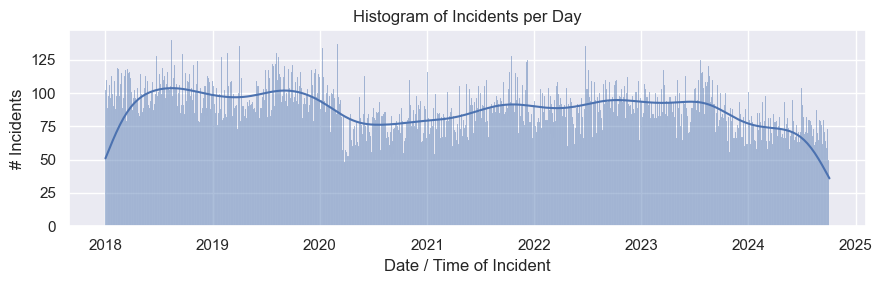

Total of 89,458 incidents from 2018-01-01 00:00:00 to 2024-10-02 20:29:00


In [48]:
plt.figure(figsize=(graph_utils.page_width, 3))
sns.histplot(data=current_clean_df, x=current_clean_df.index, bins=1000, kde=True)
# sns.histplot(data=current_clean_df, x=current_clean_df.index, discrete=True, kde=True)

plt.xlabel('Date / Time of Incident')
plt.ylabel('# Incidents')
plt.title('Histogram of Incidents per Day')

plt.tight_layout()
plt.savefig('../images/incidents_per_day.png')
plt.show()

print(f'Total of {current_clean_df.shape[0]:,d} incidents from {current_clean_df.index.min()} to {current_clean_df.index.max()}')

#### Inspect: Incidents per Year

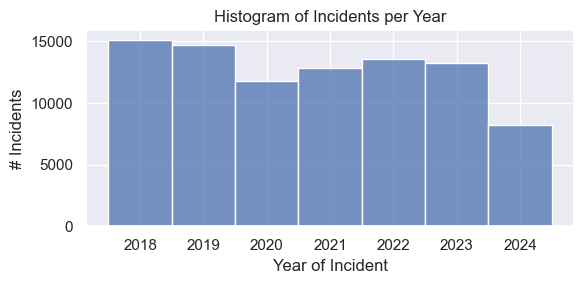

In [50]:
plt.figure(figsize=(6, 3))
sns.histplot(data=current_clean_df, x='incident_year', discrete=True)

plt.xlabel('Year of Incident')
plt.ylabel('# Incidents')
plt.title('Histogram of Incidents per Year')

plt.tight_layout()
plt.savefig('../images/incidents_per_year.png')
plt.show()

#### Inspect: Incidents by Day of Week

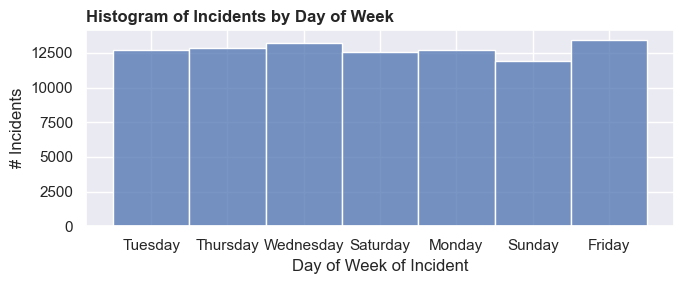

In [52]:
plt.figure(figsize=(7, 3))
sns.histplot(data=current_clean_df, x='incident_day_of_week')

plt.xlabel('Day of Week of Incident')
plt.ylabel('# Incidents')
plt.title('Histogram of Incidents by Day of Week', loc="left", fontdict={"weight": "bold"}, y=1.0)

plt.tight_layout()
plt.savefig('../images/incidents_per_DoW.png')
plt.show()

#### Create Synthetic Time Features

Our data is indexed by DateTimeStamp, but this is not very useful to work with. In addition, time has semantic meaning above just it's absolute value and concepts like weekends, holidays need to be represented in our predictions. We now introduce new synthetic features to address this issue. As we do this, we will also update the `data_utils.apply_synthetic_features()` function with our changes to centralize the codebase and also provide this for other project notebooks.

##### Convert Timestamp to [Month, Day, Hour, Minute]

Let's unpack the date and time into their components that are still missing so there is less to encode:

In [57]:
current_clean_df['hour'] = current_clean_df.index.map(lambda x: x.hour)
current_clean_df['minute'] = current_clean_df.index.map(lambda x: x.minute)
current_clean_df['day'] = current_clean_df.index.map(lambda x: x.day)
current_clean_df['month'] = current_clean_df.index.map(lambda x: x.month)

In [58]:
import calendar

temp = current_clean_df.copy()
temp.month = temp.month.map(lambda x: calendar.month_name[x])

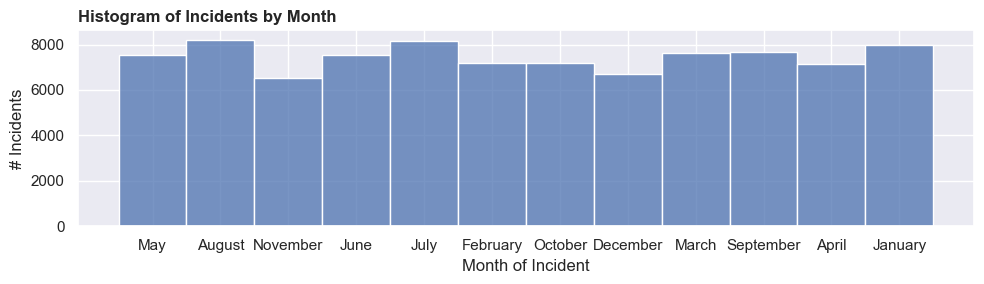

In [59]:
import calendar

plt.figure(figsize=(10, 3))
sns.histplot(data=temp, x='month', kde=False)

plt.xlabel('Month of Incident')
plt.ylabel('# Incidents')
plt.title('Histogram of Incidents by Month', loc="left", fontdict={"weight": "bold"}, y=1.0)

plt.tight_layout()
plt.savefig('../images/incidents_per_month.png')
plt.show()

##### Adding Weekends

Let's add a new feature to track incidents over a weekend, i.e. Saturday or Sunday

In [62]:
# Create mask for Sat/Sun
weekend_days = {'Monday':0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0, 'Friday':0, 'Saturday':1, 'Sunday':1}

current_clean_df['weekend'] = current_clean_df.incident_day_of_week.map(lambda x: weekend_days[x])

# current_clean_df[['incident_day_of_week', 'weekend']].head(5)

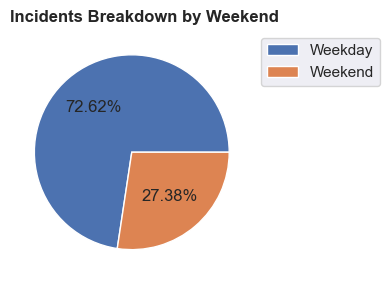

In [63]:
df_grouped = current_clean_df.groupby(['weekend'])['weekend'].count().transform(lambda x: x / x.sum() * 100)
names = ('Weekday','Weekend')

ax = df_grouped.plot(kind='pie', figsize=(10,3), #startangle=20, 
                  grid=False, ylabel='', labels=names,
                  legend=False, labeldistance=None, 
                  autopct='%1.2f%%')

ax.legend(bbox_to_anchor=(1, 1),loc='best')
plt.title('Incidents Breakdown by Weekend', loc="left", fontdict={"weight": "bold"}, y=1.0)
plt.tight_layout()
plt.savefig(Config.IMAGE_DIR / 'incidence_weekend.png')
plt.show()

##### Adding Seasons

Let's add a new feature to track incidents that may be impacted by seasons

In [66]:
# Create mask for seasons
seasons = {0:'Winter', 1:'Spring', 2:'Summer', 3:'Fall'}

current_clean_df['season'] = current_clean_df.month.map(lambda x: seasons[((x % 12) // 3)])

# current_clean_df[['month', 'season']].head(5)

In [67]:
current_clean_df.season.value_counts()

season
Summer    23911
Spring    22308
Winter    21874
Fall      21365
Name: count, dtype: int64

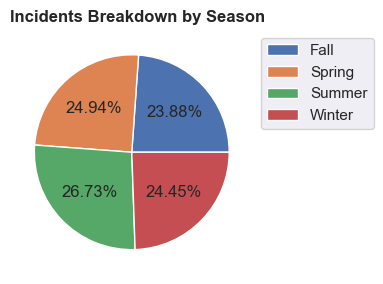

In [68]:
df_grouped = current_clean_df.groupby(['season'])['season'].count().transform(lambda x: x / x.sum() * 100)

ax = df_grouped.plot(kind='pie', figsize=(10,3), #startangle=20, 
                  grid=False, ylabel='',
                  legend=True, labeldistance=None, 
                  autopct='%1.2f%%')

ax.legend(bbox_to_anchor=(1, 1),loc='best')
plt.title('Incidents Breakdown by Season', loc="left", fontdict={"weight": "bold"}, y=1.0)
plt.tight_layout()
plt.savefig(Config.IMAGE_DIR / 'incidence_season.png')
plt.show()

##### Adding US Holidays

In [70]:
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=current_clean_df.index.min(), end=current_clean_df.index.max())

In [71]:
current_clean_df['holiday'] = current_clean_df.index.isin(holidays)

# current_clean_df.holiday.value_counts()

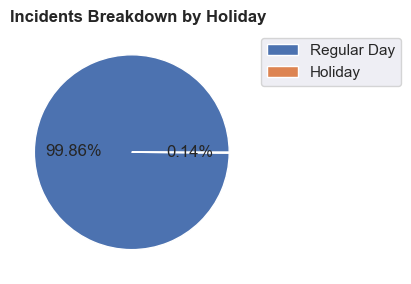

Time Range: 2018-01-01 thru 2024-10-02 has 70 holidays


In [72]:
df_grouped = current_clean_df.groupby(['holiday'])['holiday'].count().transform(lambda x: x / x.sum() * 100)
names = ('Regular Day','Holiday')

ax = df_grouped.plot(kind='pie', figsize=(10,3), #startangle=20, 
                  grid=False, ylabel='', labels=names,
                  legend=False, labeldistance=None, 
                  autopct='%1.2f%%')

ax.legend(bbox_to_anchor=(1, 1),loc='best')
plt.title('Incidents Breakdown by Holiday', loc="left", fontdict={"weight": "bold"}, y=1.0)
plt.tight_layout()
plt.savefig(Config.IMAGE_DIR / 'incidence_holiday.png')
plt.show()

print(f'Time Range: {str(current_clean_df.index.min().date())} thru {str(current_clean_df.index.max().date())} has {len(holidays)} holidays')

##### Adding Time of Day

Let's add a new feature to tell us whether it's morning (6am to noon), afternoon (noon-6pm), evening (6pm-midnight) or nighttime (after midnight):

In [75]:
current_clean_df['tod'] = current_clean_df.hour.map(lambda x: data_utils.tod_dict[x])

# current_clean_df.tod.value_counts()

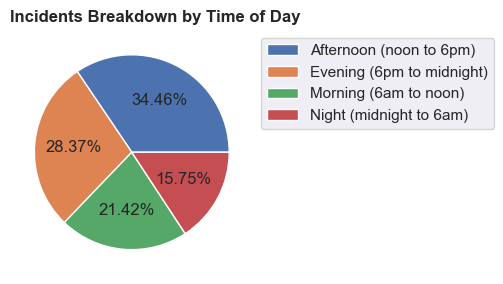

In [76]:
df_grouped = current_clean_df.groupby(['tod'])['tod'].value_counts()
names = ('Afternoon (noon to 6pm)',
         'Evening (6pm to midnight)',
         'Morning (6am to noon)',
         'Night (midnight to 6am)')

ax = df_grouped.plot(kind='pie', figsize=(10,3), #startangle=20, 
                  grid=False, ylabel='', labels=names,
                  legend=False, labeldistance=None, 
                  autopct='%1.2f%%')

ax.legend(bbox_to_anchor=(1, 1),loc='best')
plt.title('Incidents Breakdown by Time of Day', loc="left", fontdict={"weight": "bold"}, y=1.0)
plt.tight_layout()
plt.savefig(Config.IMAGE_DIR / 'incidence_tod.png')
plt.show()

In [77]:
current_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89458 entries, 2018-05-22 13:00:00 to 2018-10-02 16:53:00
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   incident_datetime         89458 non-null  object 
 1   incident_date             89458 non-null  object 
 2   incident_time             89458 non-null  object 
 3   incident_year             89458 non-null  int64  
 4   incident_day_of_week      89458 non-null  object 
 5   report_datetime           89458 non-null  object 
 6   row_id                    89458 non-null  int64  
 7   incident_id               89458 non-null  int64  
 8   incident_number           89458 non-null  int64  
 9   cad_number                69540 non-null  float64
 10  incident_code             89458 non-null  int64  
 11  incident_category         89368 non-null  object 
 12  incident_subcategory      89368 non-null  object 
 13  incident_description      

### Inspect: Geo-based Features

According to [LatLong.net](https://www.latlong.net/place/san-francisco-bay-area-ca-usa-32614.html) the San Francisco County is bounded by the following rectangle:

* Latitude Range:
  * Northern limit: 37.8330° N
  * Southern limit: 37.7031° N
* Longitude Range:
  * Western limit: -122.52279° W
  * Eastern limit: -122.3515° W

Let's make sure our data is within range.

In [80]:
print(f'Latitude: Min: {current_clean_df.latitude.min()}, Max: {current_clean_df.latitude.max()}')

Latitude: Min: 37.70798825918467, Max: 37.82999075468863


In [81]:
print(f'Longitude: Min: {current_clean_df.longitude.min()}, Max: {current_clean_df.longitude.max()}')

Longitude: Min: -122.5119400024414, Max: -122.36373901367188


SFPD did a good job for excluding bad [Latitude, Longitude] combinations! Based on this, our latitude and longitude values are within limits and includes some crimes that may have happened in the Bay or Treasure Island. 

No data cleaning required for the geo-data!

### Inspect: Incident-Specific Features

Let's look at Incident-specific features that are left for a specific Incident to understand how the data is reported:
  * incident_datetime
  * report_datetime
  * row_id
  * incident_id / incident_code
  * incident_number
  * cad_number
  * incident_category
  * incident_subcategory
  * incident_description
  * resolution

Is there an interesting incident to look at with a lot of rows?

In [85]:
current_clean_df.columns

Index(['incident_datetime', 'incident_date', 'incident_time', 'incident_year',
       'incident_day_of_week', 'report_datetime', 'row_id', 'incident_id',
       'incident_number', 'cad_number', 'incident_code', 'incident_category',
       'incident_subcategory', 'incident_description', 'resolution',
       'police_district', 'analysis_neighborhood', 'latitude', 'longitude',
       'neighborhoods', 'current_police_districts', 'hour', 'minute', 'day',
       'month', 'weekend', 'season', 'holiday', 'tod'],
      dtype='object')

In [86]:
inc_id = current_clean_df[current_clean_df.incident_id.duplicated()].incident_id.value_counts().index[0]

In [87]:
current_raw_df.query('incident_id == @inc_id')[['incident_datetime', 'report_datetime', 'incident_id', 'incident_code', 
                                                'row_id', 'incident_number', 'cad_number',
                                                'incident_category','incident_subcategory', 'incident_description', 
                                                'resolution']]

,incident_datetime,report_datetime,incident_id,incident_code,row_id,incident_number,cad_number,incident_category,incident_subcategory,incident_description,resolution
datetime,,,,,,,,,,,
2022-10-08 11:50:00,2022/10/08 11:50:00 AM,2022/10/08 12:01:00 PM,1201453,28160,120145328160,220691178,222811301.0,Malicious Mischief,Vandalism,"Malicious Mischief, Vandalism to Vehicle",Open or Active
2022-10-08 11:50:00,2022/10/08 11:50:00 AM,2022/10/08 12:01:00 PM,1201453,4134,120145304134,220691178,222811301.0,Assault,Simple Assault,Battery,Open or Active
2022-10-08 11:50:00,2022/10/08 11:50:00 AM,2022/10/08 12:01:00 PM,1201453,12030,120145312030,220691178,222811301.0,Weapons Offense,Weapons Offense,"Weapon, Deadly, Imitation or Laser Scope, Exhi...",Open or Active


The single incident, multiple rows explanation is as follows (from the [DataSF Dataset Explainer](https://sfdigitalservices.gitbook.io/dataset-explainers/sfpd-incident-report-2018-to-present#multiple-incident-codes)):

>Incident reports can have one or more associated Incident Codes. For example, an officer may have a warrant for an
>arrest and while making the arrest, discovers narcotics in the individual’s possession. The officer would record
>two Incident Codes: (1) for the warrant and (2) for the discovery of narcotics.
>
>When multiple Incident Codes exist, the Incident ID, Incident Number and CAD Numbers remain the same and the
>Row ID field can be used as a unique identifier for each row of data. An example is provided below.

Since we are interested in predicting the `incident_category` based on time and location, we'll retain  all three rows, each with a different category, but remove the columns that merge them into a single incident. This gives us more training data with a whetted outcome, i.e. target variable.

So we will drop the following columns:

  * incident_datetime / report_datetime
  * incident_id / incident_code / row_id / incident_number / cad_number
  * incident_subcategory
  * incident_description

and only retain `incident_category` as our target variable - we will look at `resolution` separately.

In [89]:
drop_cols_incident = ['incident_datetime', 'report_datetime', 
                      'incident_id', 'incident_code', 'row_id', 'incident_number', 'cad_number',
                      'incident_subcategory', 'incident_description'
                     ]

current_clean_df = data_utils.preprocess_data(current_clean_df, drop_cols_incident)

Pre-processing ... 
... Dropping unwanted columns ... 
... preprocess_drop_cols: Column incident_datetime dropped
... preprocess_drop_cols: Column report_datetime dropped
... preprocess_drop_cols: Column incident_id dropped
... preprocess_drop_cols: Column incident_code dropped
... preprocess_drop_cols: Column row_id dropped
... preprocess_drop_cols: Column incident_number dropped
... preprocess_drop_cols: Column cad_number dropped
... preprocess_drop_cols: Column incident_subcategory dropped
... preprocess_drop_cols: Column incident_description dropped
... Done


#### Inspect: Resolution

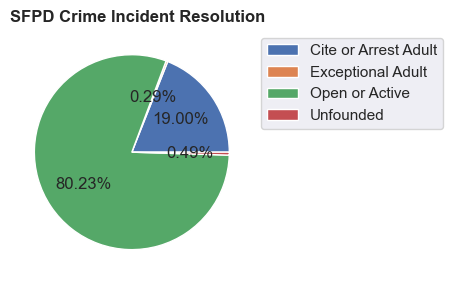

In [91]:
df_grouped = current_clean_df.groupby(['resolution'])['resolution'].count().transform(lambda x: x / x.sum() * 100)
ax = df_grouped.plot(kind='pie', figsize=(10,3), #startangle=20, 
                  grid=False, ylabel='',
                  legend=True, labeldistance=None, 
                  autopct='%1.2f%%')

ax.legend(bbox_to_anchor=(1, 1),loc='best')
plt.title('SFPD Crime Incident Resolution', loc="left", fontdict={"weight": "bold"}, y=1.0)
plt.tight_layout()
plt.savefig(Config.IMAGE_DIR / 'incidence_resolution.png')
plt.show()

In [92]:
current_clean_df.resolution.value_counts()

resolution
Open or Active          71769
Cite or Arrest Adult    16994
Unfounded                 435
Exceptional Adult         260
Name: count, dtype: int64

Both the `Unfounded` and `Exceptional Adult` resolution types will results in the case being dismissed the case so we can remove these rows.

In [94]:
current_clean_df = current_clean_df.query('resolution != "Unfounded" and resolution != "Exceptional Adult"')

In [95]:
current_clean_df.resolution.value_counts()

resolution
Open or Active          71769
Cite or Arrest Adult    16994
Name: count, dtype: int64

#### Inspect: Police Districts

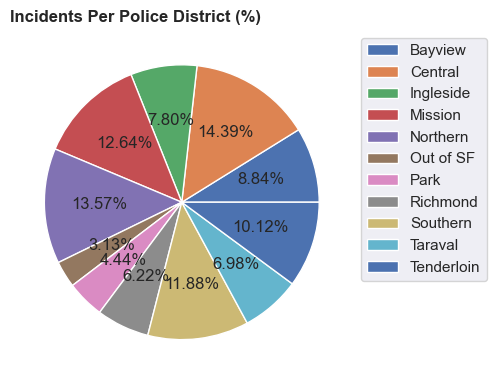

In [97]:
# Let's look at the Incident rates per police_district

df_grouped = current_clean_df.groupby(['police_district'])['police_district'].count().transform(lambda x: x / x.sum() * 100)
plt.figure(figsize=(6,4))
ax = df_grouped.plot(kind='pie', grid=True, ylabel='', labeldistance=None, 
                     legend=True, autopct='%1.2f%%')

ax.legend(bbox_to_anchor=(1, 1),loc='best')
plt.title('Incidents Per Police District (%)', loc="left", fontdict={"weight": "bold"}, y=1.0)
plt.tight_layout()
plt.savefig(Config.IMAGE_DIR / 'incidents_by_pd.png')
plt.show()

In [98]:
current_clean_df.current_police_districts.value_counts()

current_police_districts
6.0     12199
4.0     12039
3.0     10972
1.0     10577
5.0      8402
2.0      7919
9.0      6743
10.0     6362
8.0      4785
7.0      3710
Name: count, dtype: int64

We can safely drop the `current_police_districts` column as it's not very useful, we can use `police_district` 
as a categorical feature instead. However, we need to remove the incidents that are `Out of SF`.

In [100]:
current_clean_df = current_clean_df.query('police_district != "Out of SF"')

In [101]:
drop_cols_pd = ['current_police_districts']

current_clean_df = data_utils.preprocess_data(current_clean_df, drop_cols_pd)

Pre-processing ... 
... Dropping unwanted columns ... 
... preprocess_drop_cols: Column current_police_districts dropped
... Done


Now that we have fewer features, I will now rename the incident-specific columns to make it easier to understand our features:

In [103]:
current_clean_df = current_clean_df.rename(columns={'incident_date':'date',
                                                    'incident_time':'time',
                                                    'incident_year':'year',
                                                    'incident_day_of_week':'dow',
                                                    'incident_category':'category'
                                                   })

In [104]:
print('COMPLETENESS CHECK: Percent non-null values in each column')
current_clean_df.isnull().sum().transform(lambda x: (1 - (x / current_clean_df.shape[0])) * 100).round(2)

COMPLETENESS CHECK: Percent non-null values in each column


date                     100.00
time                     100.00
year                     100.00
dow                      100.00
category                  99.90
resolution               100.00
police_district          100.00
analysis_neighborhood     96.49
latitude                  96.51
longitude                 96.51
neighborhoods             94.67
hour                     100.00
minute                   100.00
day                      100.00
month                    100.00
weekend                  100.00
season                   100.00
holiday                  100.00
tod                      100.00
dtype: float64

#### Inspect: Neighborhoods

Similar to the police disctricts, we have two redundant columns `neighborhoods` and `analysis_neighborhood`:

In [107]:
current_clean_df.analysis_neighborhood.value_counts()

analysis_neighborhood
Mission                           9000
Tenderloin                        8880
South of Market                   6834
Financial District/South Beach    6450
Bayview Hunters Point             5588
North Beach                       2741
Western Addition                  2683
Sunset/Parkside                   2448
Nob Hill                          2430
Castro/Upper Market               2398
Marina                            2360
Hayes Valley                      2297
Russian Hill                      1963
Outer Richmond                    1892
West of Twin Peaks                1730
Bernal Heights                    1635
Excelsior                         1499
Pacific Heights                   1480
Chinatown                         1386
Potrero Hill                      1360
Haight Ashbury                    1354
Mission Bay                       1284
Outer Mission                     1236
Inner Richmond                    1083
Inner Sunset                      1081
Lak

In [108]:
current_clean_df.neighborhoods.value_counts()

neighborhoods
32.0    8095
53.0    6739
20.0    5714
19.0    2846
21.0    2708
        ... 
2.0       39
69.0      37
68.0      36
7.0       22
70.0      12
Name: count, Length: 116, dtype: int64

We will drop the `neighborhoods` column and re-use it's name for the `analysis_neighborhood` column:

In [110]:
drop_cols_neighborhoods = ['neighborhoods']

current_clean_df = data_utils.preprocess_data(current_clean_df, drop_cols_neighborhoods)

Pre-processing ... 
... Dropping unwanted columns ... 
... preprocess_drop_cols: Column neighborhoods dropped
... Done


In [111]:
current_clean_df.rename(columns={'analysis_neighborhood':'neighborhood'}, inplace=True)

### Inspect: Target Variable - Category

Let's take a look at our target variable `category` to get an understanding of the relationships with the other features.

#### Categories: Histogram

In [115]:
current_clean_df.columns

Index(['date', 'time', 'year', 'dow', 'category', 'resolution',
       'police_district', 'neighborhood', 'latitude', 'longitude', 'hour',
       'minute', 'day', 'month', 'weekend', 'season', 'holiday', 'tod'],
      dtype='object')

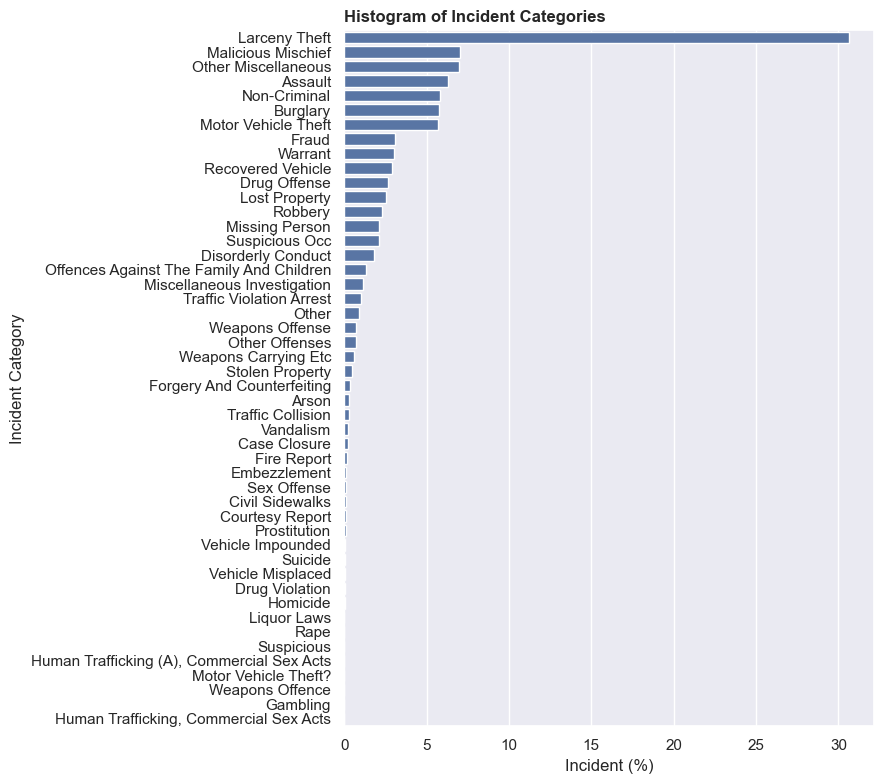

In [116]:
plt.figure(figsize=(graph_utils.page_width, 8))

cats = current_clean_df.category.value_counts()   # save for later
sns.barplot(current_clean_df.category.value_counts(normalize=True) * 100, orient='h')

plt.xlabel('Incident (%)')
plt.ylabel('Incident Category')
plt.title('Histogram of Incident Categories', loc="left", fontdict={"weight": "bold"}, y=1.0)

plt.tight_layout()
plt.savefig(Config.IMAGE_DIR / 'incidents_per_day.png')
plt.show()


#### Inspect: Categories Unique Values

In [118]:
print(f'Total of {cats.shape[0]:,d} categories:')

# cats.head(top_n)
cats.sort_index()

Total of 48 categories:


category
Arson                                           256
Assault                                        5398
Burglary                                       4964
Case Closure                                    195
Civil Sidewalks                                  89
Courtesy Report                                  88
Disorderly Conduct                             1534
Drug Offense                                   2294
Drug Violation                                   22
Embezzlement                                    114
Fire Report                                     127
Forgery And Counterfeiting                      293
Fraud                                          2670
Gambling                                          4
Homicide                                         19
Human Trafficking (A), Commercial Sex Acts       10
Human Trafficking, Commercial Sex Acts            3
Larceny Theft                                 26312
Liquor Laws                                      15
Los

Looking at the `category` distribution, we notice the following categories:

* `Human Trafficking (A), Commercial Sex Acts` (10 occurences) and `Human Trafficking, Commercial Sex Acts` (3 occurences): Since they are so few, we'll comnine them into a single `Human Trafficking (Combined)` class
* `Motor Vehicle Theft` (4,900 occurences) and `Motor Vehicle Theft?` (8 occurences) are similar enough that I converted them into the dominant class
* `Weapons Offense` (619 occurennces) `Weapons Offence` (4 occurences) look like an entry error, so they were converted to the dominant class

In [120]:
_ = data_utils.fix_data_artifacts(current_clean_df)

Fixing data artifacts (in-place) ... 
... Category column:
    ..."Human Trafficking*"
    ..."Motor Vehicle Theft"
    ..."Weapons Offence"
Done


In [121]:
current_clean_df.category.value_counts()

category
Larceny Theft                               26312
Malicious Mischief                           6052
Other Miscellaneous                          5972
Assault                                      5398
Non-Criminal                                 4984
Burglary                                     4964
Motor Vehicle Theft                          4908
Fraud                                        2670
Warrant                                      2612
Recovered Vehicle                            2477
Drug Offense                                 2294
Lost Property                                2190
Robbery                                      1985
Missing Person                               1817
Suspicious Occ                               1811
Disorderly Conduct                           1534
Offences Against The Family And Children     1158
Miscellaneous Investigation                   960
Traffic Violation Arrest                      876
Other                                    

#### Categories: By Year

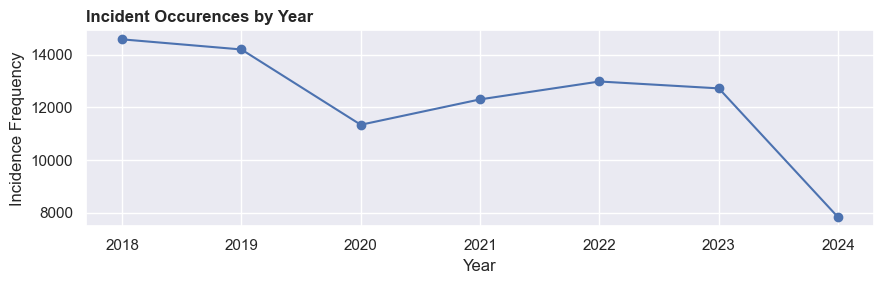

In [123]:
plt.figure(figsize=(graph_utils.page_width, 3))

current_clean_df.year.value_counts().sort_index().plot(marker='o')

plt.xlabel('Year')
plt.ylabel('Incidence Frequency')
plt.title('Incident Occurences by Year', loc="left", fontdict={"weight": "bold"}, y=1.0)

plt.tight_layout()
plt.savefig(Config.IMAGE_DIR / 'incidents_per_year.png')
plt.show()

#### Categories - Top 10: By Year

In [125]:
top_n = 10
top_cats = cats.index[0:top_n]

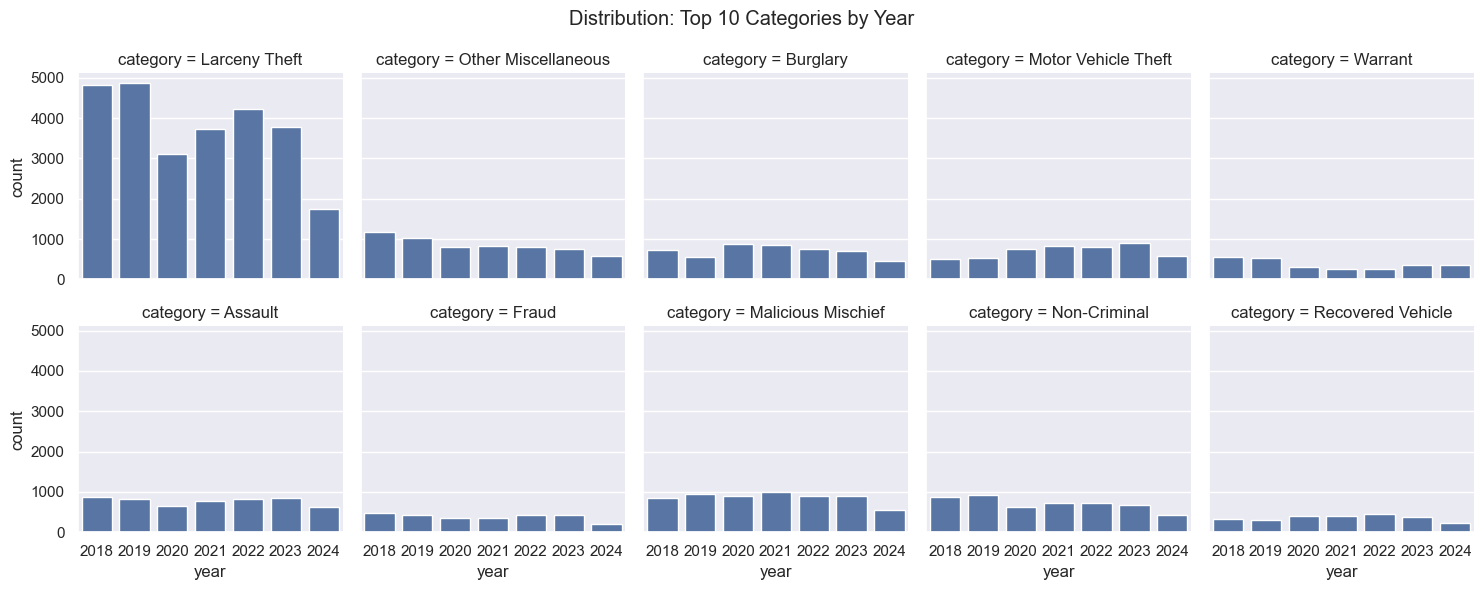

In [126]:
g = sns.FacetGrid(current_clean_df[['category', 'year']].query('category in @top_cats'), 
                  col='category', col_wrap=5)
g = g.map(sns.countplot, 'year', order=np.sort(current_clean_df['year'].unique()))
# g.set_xticklabels(rotation=30)

plt.suptitle(f'Distribution: Top {top_n} Categories by Year')
plt.ylabel('Incidents / Year')
plt.tight_layout()
plt.savefig(Config.IMAGE_DIR / 'incidents_top_n_by_year.png')

plt.show()

#### Categories: By Police Disctrict

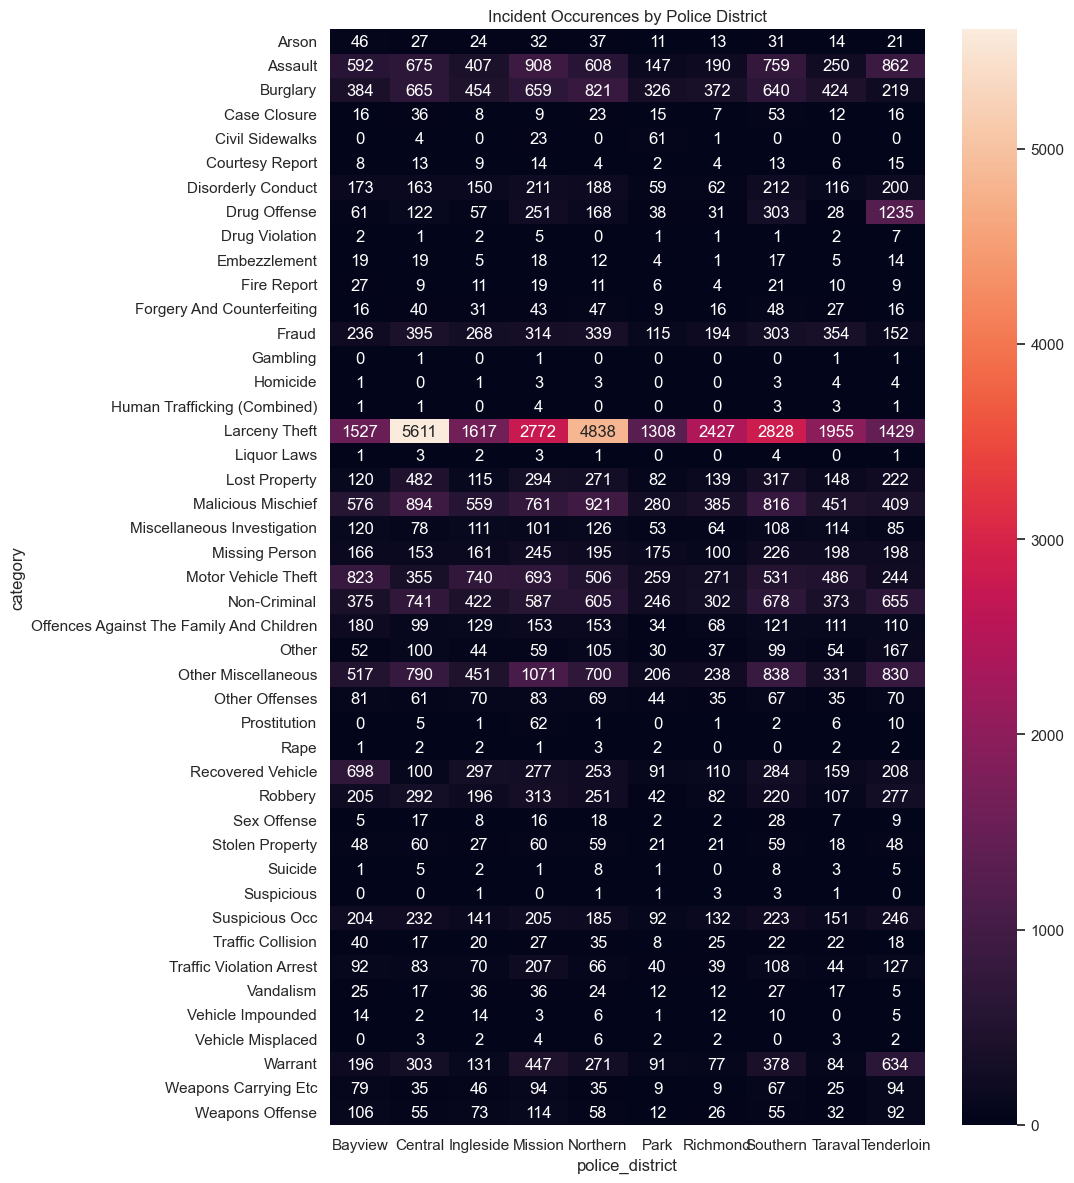

In [128]:
heatmap_data = pd.crosstab(current_clean_df['category'], current_clean_df['police_district'])

plt.figure(figsize=(graph_utils.page_width+2, 12))

sns.heatmap(heatmap_data, annot=True, fmt='d')

# plt.xlabel('Police District')
# plt.ylabel('Category')
plt.title('Incident Occurences by Police District')

plt.tight_layout()
plt.savefig(Config.IMAGE_DIR / 'incidents_per_district_heatmap.png')
plt.show()

### Drop Nulls

We have now gotten rid of most of the unwanted data and most of the columns have above 94% non-null data. This is sufficient data for training, so we will drop all null rows for now:

In [131]:
print('COMPLETENESS CHECK: Percent non-null values in each column')
current_clean_df.isnull().sum().transform(lambda x: (1 - (x / current_clean_df.shape[0])) * 100).round(2)

COMPLETENESS CHECK: Percent non-null values in each column


date               100.00
time               100.00
year               100.00
dow                100.00
category            99.90
resolution         100.00
police_district    100.00
neighborhood        96.49
latitude            96.51
longitude           96.51
hour               100.00
minute             100.00
day                100.00
month              100.00
weekend            100.00
season             100.00
holiday            100.00
tod                100.00
dtype: float64

In [132]:
current_clean_df.dropna(inplace=True)

In [133]:
print('COMPLETENESS CHECK: Percent non-null values in each column')
current_clean_df.isnull().sum().transform(lambda x: (1 - (x / current_clean_df.shape[0])) * 100).round(2)

COMPLETENESS CHECK: Percent non-null values in each column


date               100.0
time               100.0
year               100.0
dow                100.0
category           100.0
resolution         100.0
police_district    100.0
neighborhood       100.0
latitude           100.0
longitude          100.0
hour               100.0
minute             100.0
day                100.0
month              100.0
weekend            100.0
season             100.0
holiday            100.0
tod                100.0
dtype: float64

In [134]:
current_clean_df.head(2)

,date,time,year,dow,category,resolution,police_district,neighborhood,latitude,longitude,hour,minute,day,month,weekend,season,holiday,tod
datetime,,,,,,,,,,,,,,,,,,
2024-08-01 08:01:00,2024/08/01,08:01,2024,Thursday,Other Miscellaneous,Open or Active,Mission,Mission,37.768272,-122.419983,8,1,1,8,0,Summer,False,Morning
2021-11-25 23:30:00,2021/11/25,23:30,2021,Thursday,Burglary,Open or Active,Northern,Haight Ashbury,37.773757,-122.432467,23,30,25,11,0,Fall,False,Evening


## Cross-check Preprocessing

Read in the preprocessed data from utility function and validate against the currently _cleaned_ data 
as part of the data investigation

In [137]:
current_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82888 entries, 2024-08-01 08:01:00 to 2018-10-02 16:53:00
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             82888 non-null  object 
 1   time             82888 non-null  object 
 2   year             82888 non-null  int64  
 3   dow              82888 non-null  object 
 4   category         82888 non-null  object 
 5   resolution       82888 non-null  object 
 6   police_district  82888 non-null  object 
 7   neighborhood     82888 non-null  object 
 8   latitude         82888 non-null  float64
 9   longitude        82888 non-null  float64
 10  hour             82888 non-null  int64  
 11  minute           82888 non-null  int64  
 12  day              82888 non-null  int64  
 13  month            82888 non-null  int64  
 14  weekend          82888 non-null  int64  
 15  season           82888 non-null  object 
 16  holiday          82888 

In [138]:
temp = data_utils.preprocess_data(current_raw_df.copy())
temp = data_utils.apply_synthetic_features(temp)

crosscheck = 'PASSED' if (temp.shape[0] == current_clean_df.shape[0]
                          and temp.shape[1] == current_clean_df.shape[1]) else 'FAILED'
print('\n\nCROSSCHECK {}: raw: {} -> pre-processed: {} == cleaned: {}\n\n'
      .format(crosscheck, current_raw_df.shape, temp.shape, current_clean_df.shape))

Pre-processing ... 
... Dropping unwanted columns ... 
... preprocess_drop_cols: Column Unnamed: 0 dropped
... preprocess_drop_cols: Column esncag_-_boundary_file dropped
... preprocess_drop_cols: Column central_market/tenderloin_boundary_polygon_-_updated dropped
... preprocess_drop_cols: Column civic_center_harm_reduction_project_boundary dropped
... preprocess_drop_cols: Column hsoc_zones_as_of_2018-06-05 dropped
... preprocess_drop_cols: Column invest_in_neighborhoods_(iin)_areas dropped
... preprocess_drop_cols: Column report_type_code dropped
... preprocess_drop_cols: Column report_type_description dropped
... preprocess_drop_cols: Column filed_online dropped
... preprocess_drop_cols: Column intersection dropped
... preprocess_drop_cols: Column cnn dropped
... preprocess_drop_cols: Column point dropped
... preprocess_drop_cols: Column supervisor_district dropped
... preprocess_drop_cols: Column supervisor_district_2012 dropped
... preprocess_drop_cols: Column current_supervisor_d

In [139]:
# for col in zip(temp.columns, current_clean_df.columns):
#     print (col)

In [140]:
current_clean_df.head(2)

,date,time,year,dow,category,resolution,police_district,neighborhood,latitude,longitude,hour,minute,day,month,weekend,season,holiday,tod
datetime,,,,,,,,,,,,,,,,,,
2024-08-01 08:01:00,2024/08/01,08:01,2024,Thursday,Other Miscellaneous,Open or Active,Mission,Mission,37.768272,-122.419983,8,1,1,8,0,Summer,False,Morning
2021-11-25 23:30:00,2021/11/25,23:30,2021,Thursday,Burglary,Open or Active,Northern,Haight Ashbury,37.773757,-122.432467,23,30,25,11,0,Fall,False,Evening


We're ready for modeling now!